
원본데이터 - 로그데이터

원본데이터  - 유저 특성 데이터 - 클러스터링 이후에 결과 집단의 특성을 토대로 비즈니스 전략 수립 가능


            - 비즈니스 전략 데이터


1. 유저 분석을 위한 유저 기준으로 정리된 데이터 - 클러스터링
=> 유저특성지표

row의 단위 : 유저 1명
col의 단위 : 해당 유저에 대한 통계량

EDA해서 나온 요소들을 통합하기

	1) R, F, M
	2) 구매횟수대비 쿠폰사용율
  	3) 평균구매주기






2. 마케팅, 비즈니스 전략을 위한 데이터
=> 경향성 지표


	1) ROAS 지표 = 광고비 대비 매출액(수익)
	   단위기간 중 총 광고비용이 높은 특정 기간
      	   특정 기간 중에 거래량이 많은 집단 특정
	   전략 : 1)결과값을 보고 저희 주관이 들어간 요소

	2) 오프라인 비용으로부터 초래되는 비효율 줄이기
                주장 : 오프라인 마케팅이 효과가 미비하다
                         효과가 상대적으로 좋은 온라인이 오프라인에 맞춰서 조정되는 것이 비효율이다
	   
                오프라인비용 : 일주일단위로 조정 - 비탄력적 요소
                온라인비용 : 하루 단위로 조정 - 탄력적 요소

	    온라인, 오프라인 7일 이동평균 상관관계 = 0.74

	   총 마케팅비용과 총매출 간의 관계        = 0.14
                온라인비용이동평균과 총매출간의 관계 = 0.2












목표1. 클러스터링 해보기
그것을 위한 숙제
1. RFM 간소화하기(클러스터링과의 비교군) => 7개 그룹정도?
    5 * 5 * 2 = 
    - 참고 및 평가요소(+ 실루엣 점수)
    1) 클러스터링을 통해 나온 그룹을 어떤 그룹으로 정의할지의 참고사항
    2) 우리만의 클러스터링이 가지고 있는 요소(ex. 우리가 한 클러스터링의 vip는 ㅇㅇㅇ가 RFM에 비해 높다, 대신 ㅇㅇㅇ는 관대하다)
    분류된 고객층 중에서 특정층을 공략하기 => 최종목표
2. Monetary별 가중치 해결하기
3. EDA를 통한 유저 특성 컬럼 추가하기


목표2. ROAS에 요소 추가



## 2023-04-09
### 1. rfm의 컬럼 기준으로 EDA
        - 컬럼들의 분포를 기준으로 bins값을 다시 정한다든지 등

### 2. rfm의 카테고리 컬럼의 차원 축소
        - 최다구매카테고리 : 당일에 결정
        - 지역 : 5개
        - 최다구매월 : 분기로 축소
        - 성별 : 2개

### 3. 클러스터링
        - 적절한 클러스터링 기법과 클러스터의 수, 각 센터로이드의 특징

## 클러스터링을 강화하는 방향
### 1. 유저 중심 컬럼

In [60]:
import numpy as np
import pandas as pd

import datetime as dt
import time
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

import re

import warnings
warnings.filterwarnings('ignore')

In [61]:
df1 = pd.read_csv('open/Onlinesales_info.csv')
df2 = pd.read_csv('open/Customer_info.csv')
df3 = pd.read_csv('open/Discount_info.csv')
df4 = pd.read_csv('open/Marketing_info.csv')
df5 = pd.read_csv('open/Tax_info.csv')

In [62]:
df = pd.merge(df1, df2, how='left', on='고객ID')
df = pd.merge(df, df5, how='left', on='제품카테고리')

df['거래날짜'] = pd.to_datetime(df['거래날짜'])
df['월'] = df['거래날짜'].dt.month

In [63]:
def month_shift(x):
    dict = {1:'Jan',
            2:'Feb',
            3:'Mar',
            4:'Apr',
            5:'May',
            6:'Jun',
            7:'Jul',
            8:'Aug',
            9:'Sep',
            10:'Oct',
            11:'Nov',
            12:'Dec'}
    
    return dict[x]

In [64]:
df['월'] = df['월'].apply(month_shift)

In [65]:
df = pd.merge(df, df3, how='left', on=['월', '제품카테고리'])

In [66]:
df4['날짜'] = pd.to_datetime(df4['날짜'])
df = pd.merge(df, df4, how='left', left_on='거래날짜', right_on='날짜')

df = df.drop('날짜', axis=1)

In [67]:
df.head()

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,성별,고객지역,가입기간,GST,월,쿠폰코드,할인율,오프라인비용,온라인비용
0,USER_1358,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used,남,Chicago,12,0.10,Jan,ELEC10,10.0,4500,2424.5
1,USER_1358,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used,남,Chicago,12,0.10,Jan,ELEC10,10.0,4500,2424.5
2,USER_1358,Transaction_0002,2019-01-01,Product_0904,Office,1,2.05,6.5,Used,남,Chicago,12,0.10,Jan,OFF10,10.0,4500,2424.5
3,USER_1358,Transaction_0003,2019-01-01,Product_0203,Apparel,5,17.53,6.5,Not Used,남,Chicago,12,0.18,Jan,SALE10,10.0,4500,2424.5
4,USER_1358,Transaction_0003,2019-01-01,Product_0848,Bags,1,16.50,6.5,Used,남,Chicago,12,0.18,Jan,AIO10,10.0,4500,2424.5


In [68]:
df.to_csv('merge.csv')

In [69]:
df.head()

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,성별,고객지역,가입기간,GST,월,쿠폰코드,할인율,오프라인비용,온라인비용
0,USER_1358,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used,남,Chicago,12,0.10,Jan,ELEC10,10.0,4500,2424.5
1,USER_1358,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used,남,Chicago,12,0.10,Jan,ELEC10,10.0,4500,2424.5
2,USER_1358,Transaction_0002,2019-01-01,Product_0904,Office,1,2.05,6.5,Used,남,Chicago,12,0.10,Jan,OFF10,10.0,4500,2424.5
3,USER_1358,Transaction_0003,2019-01-01,Product_0203,Apparel,5,17.53,6.5,Not Used,남,Chicago,12,0.18,Jan,SALE10,10.0,4500,2424.5
4,USER_1358,Transaction_0003,2019-01-01,Product_0848,Bags,1,16.50,6.5,Used,남,Chicago,12,0.18,Jan,AIO10,10.0,4500,2424.5


In [70]:
user_region = pd.DataFrame(df.groupby('고객ID')['고객지역'].apply(lambda x: x.value_counts().idxmax()))

In [71]:
mode_category = pd.DataFrame(df.groupby('고객ID')['제품카테고리'].apply(lambda x: x.value_counts().idxmax()))

In [72]:
df['쿠폰코드'] = df['쿠폰코드'].fillna(np.nan)
df['할인율'] = df['할인율'].fillna(0)

In [73]:
def true_discount(x):
    if x == 'Used':
        return 1
    else:
        return 0

In [74]:
df['true_discount'] = df['쿠폰상태'].apply(true_discount)

In [75]:
df.head()

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,성별,고객지역,가입기간,GST,월,쿠폰코드,할인율,오프라인비용,온라인비용,true_discount
0,USER_1358,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used,남,Chicago,12,0.10,Jan,ELEC10,10.0,4500,2424.5,1
1,USER_1358,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used,남,Chicago,12,0.10,Jan,ELEC10,10.0,4500,2424.5,1
2,USER_1358,Transaction_0002,2019-01-01,Product_0904,Office,1,2.05,6.5,Used,남,Chicago,12,0.10,Jan,OFF10,10.0,4500,2424.5,1
3,USER_1358,Transaction_0003,2019-01-01,Product_0203,Apparel,5,17.53,6.5,Not Used,남,Chicago,12,0.18,Jan,SALE10,10.0,4500,2424.5,0
4,USER_1358,Transaction_0003,2019-01-01,Product_0848,Bags,1,16.50,6.5,Used,남,Chicago,12,0.18,Jan,AIO10,10.0,4500,2424.5,1


거래ID	     - F(count)
거래날짜     - 기준(날짜별 금액), 고유거래일(nunique)
제품ID	    - 
제품카테고리 - 최다구매카테고리
수량        - 평균수량
평균금액    - 수량, 할인율, GST 배송료 등과 결합하여 총금액
배송료	    - (총금액 계산을 위한 평균 배송료)
쿠폰상태    - 구매횟수대비쿠폰사용율, 총할인금액, clicked 비율
성별	    - 성별은 성별
고객지역	- 지역은 지역
가입기간	- 기간은 기간
GST	       - 총납세액
월	       - 최다구매월, 해당월의 거래수
할인율	    - 총금액 계산시에 사용, 평균 할인율(not used = 0)

4개씩 분담해서 만들어오기

### 1. raw 데이터 join만 해놓은   df                                
                    
- ~~총금액(row단위) ~~                        
- ~~(총금액 계산을 위한 평균 배송료)  ~~      
- ~~납세액(row)~~

### 2. user별로 groupby한 rfm
- ~~F(count)~~
- 고유거래일(nunique)
- ~~최다구매카테고리~~    
- 평균수량 
- ~~총금액(유저단위)~~
- ~~구매횟수대비쿠폰사용율~~
- 총할인금액
- clicked 비율
- 성별, 지역, 기간
- ~~총납세액(유저단위)~~
- 최다구매월
- 해당월의 거래수
- 평균 할인율(not used = 0)



1) 준범                                                               
- 총금액(유저단위)                     
- 총금액(row단위)                    
- 납세액(row)                           
- (총금액 계산을 위한 평균 배송료)        
- 총납세액(유저단위)

2) 정식

- 고유거래일(nunique)
- 평균수량 

3) 서인
- 총할인금액
- clicked 비율
- 성별, 지역, 기간

4) 경화
- 최다구매월
- 해당월의 거래수
- 평균 할인율(not used = 0)

In [76]:
transfer = pd.DataFrame(df.groupby(['고객ID', '거래ID'])['배송료'].mean() / df.groupby(['고객ID', '거래ID'])['제품카테고리'].count())
transfer = transfer.reset_index()
transfer = transfer.rename(columns={0:'평균배송료'})


In [77]:
df = pd.merge(df, transfer, how='left', on=['고객ID', '거래ID'])

In [78]:
df['납세액'] = df['수량'] * df['평균금액'] * df['GST']

In [79]:
df['총금액'] = (df['평균금액'] * ((100 - (df['true_discount'] * df['할인율'])) / 100) * df['수량']) + df['평균배송료'] + df['납세액']  # 고객이 최종적으로 부담하는 금액


In [80]:
today_date = dt.datetime(2019,12,31)
rfm = pd.DataFrame(df.groupby('고객ID').agg({'거래ID':'nunique',
                          '총금액':'sum',
                          '거래날짜': lambda x: (today_date - x.max()).days,
                          '납세액':'sum'}))

rfm = rfm.rename(columns={'거래ID':'Frequency',
                          '총금액':'Monetary',
                          '거래날짜':'Recency',
                          '납세액':'총납세액'})
rfm = rfm[['Recency', 'Frequency', 'Monetary', '총납세액']]

In [81]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1468 entries, USER_0000 to USER_1467
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Recency    1468 non-null   int64  
 1   Frequency  1468 non-null   int64  
 2   Monetary   1468 non-null   float64
 3   총납세액       1468 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 57.3+ KB


In [82]:
rfm.head()

,Recency,Frequency,Monetary,총납세액
고객ID,,,,
USER_0000,107,1,101.3912,4.6982
USER_0001,59,31,15407.7190,2067.9070
USER_0002,73,8,1596.0858,203.6008
USER_0003,17,11,1438.5072,148.2642
USER_0004,107,13,1541.9718,151.7598


In [83]:
temp = pd.DataFrame(df.groupby(['고객ID', '거래ID'])['수량'].sum()).reset_index()

mean_purchase_quantity = temp.groupby('고객ID')['수량'].mean().reset_index()
# 'rfm' 테이블에 고객ID를 기준으로 merge
rfm = pd.merge(rfm, mean_purchase_quantity, on='고객ID', how='left')

# 컬럼명 변경
rfm.rename(columns={'수량': '평균구매수량'}, inplace=True)
rfm.head()

,고객ID,Recency,Frequency,Monetary,총납세액,평균구매수량
0,USER_0000,107,1,101.3912,4.6982,3.000000
1,USER_0001,59,31,15407.7190,2067.9070,11.032258
2,USER_0002,73,8,1596.0858,203.6008,26.125000
3,USER_0003,17,11,1438.5072,148.2642,1.909091
4,USER_0004,107,13,1541.9718,151.7598,4.307692


In [84]:
kh_mon = df.groupby(['고객ID', '월'])['거래ID'].nunique().reset_index(name='구매횟수')
kh_mon = kh_mon.loc[kh_mon.groupby('고객ID')['구매횟수'].idxmax()]
kh_mon = kh_mon.rename(columns={'월':'최다구매월'})


df['real_discount'] = df['할인율'] * df['true_discount']
dis_kh = df.groupby('고객ID')['real_discount'].mean().reset_index()
dis_kh['real_discount'] = dis_kh['real_discount'].round(2)
dis_kh = dis_kh.rename(columns={'real_discount':'평균할인율'})

rfm= pd.merge(rfm,kh_mon, how='inner',on='고객ID')
rfm= pd.merge(rfm,dis_kh, how='inner',on='고객ID')
rfm

,고객ID,Recency,Frequency,Monetary,총납세액,평균구매수량,최다구매월,구매횟수,평균할인율
0,USER_0000,107,1,101.3912,4.6982,3.000000,Sep,1,30.00
1,USER_0001,59,31,15407.7190,2067.9070,11.032258,Nov,18,8.00
2,USER_0002,73,8,1596.0858,203.6008,26.125000,Jun,4,11.74
3,USER_0003,17,11,1438.5072,148.2642,1.909091,Dec,11,10.59
4,USER_0004,107,13,1541.9718,151.7598,4.307692,Sep,13,9.17
...,...,...,...,...,...,...,...,...,...
1463,USER_1463,270,3,678.7202,51.2202,15.333333,Apr,3,4.29
1464,USER_1464,87,19,2631.9586,277.1706,7.421053,Aug,10,9.25
1465,USER_1465,194,2,128.5234,18.0264,5.000000,Apr,1,3.75
1466,USER_1466,69,1,333.8000,29.8000,2.000000,Oct,1,0.00


In [85]:
unique_transaction_date = df.groupby('고객ID')['거래날짜'].nunique()

# 'rfm' 테이블에 고객ID를 기준으로 merge
rfm = pd.merge(rfm, unique_transaction_date, on='고객ID', how='left')

# 컬럼명 변경
rfm.rename(columns={'거래날짜': '고유거래일수'}, inplace=True)
rfm.head()

,고객ID,Recency,Frequency,Monetary,총납세액,평균구매수량,최다구매월,구매횟수,평균할인율,고유거래일수
0,USER_0000,107,1,101.3912,4.6982,3.000000,Sep,1,30.00,1
1,USER_0001,59,31,15407.7190,2067.9070,11.032258,Nov,18,8.00,3
2,USER_0002,73,8,1596.0858,203.6008,26.125000,Jun,4,11.74,2
3,USER_0003,17,11,1438.5072,148.2642,1.909091,Dec,11,10.59,1
4,USER_0004,107,13,1541.9718,151.7598,4.307692,Sep,13,9.17,1


In [86]:
coupon = pd.DataFrame(df.groupby('고객ID')['쿠폰상태'].value_counts() / df.groupby('고객ID')['쿠폰상태'].count())

coupon_core = pd.DataFrame(coupon.loc[([i if i != 0 else 0 for i in df['고객ID'].unique()], 'Used'), :].sort_index())


rfm = pd.merge(rfm, coupon_core, how='left', on='고객ID').fillna(0)
rfm = rfm.rename(columns={'쿠폰상태':'쿠폰사용률'})

In [87]:
rfm['ratio'] = rfm['쿠폰사용률'] / rfm['Frequency']
rfm = rfm.drop('쿠폰사용률', axis=1)

In [88]:
last_date = dt.datetime(2019, 12, 31)

date = df.sort_values(['고객ID', '거래날짜'])[['고객ID', '거래날짜']].drop_duplicates()
date['구매주기'] = date.groupby('고객ID')['거래날짜'].diff().fillna(last_date-date['거래날짜'])

avg_buying = pd.DataFrame(date.groupby('고객ID')['구매주기'].mean()).reset_index()


rfm = pd.merge(rfm, avg_buying, how='left', on='고객ID').rename(columns={'구매주기':'평균구매주기'})

rfm['평균구매주기'] = rfm['평균구매주기'].dt.days

In [89]:
# 클러스터링에 사용할 유저 특성 테이블
rfm = pd.merge(rfm, mode_category, how='left', on='고객ID')

In [126]:
rfm = rfm.rename(columns={'제품카테고리':'최다구매카테고리',
                          '구매횟수':'당월구매횟수'})
rfm

,고객ID,Recency,Frequency,Monetary,총납세액,평균구매수량,최다구매월,당월구매횟수,평균할인율,고유거래일수,...,평균구매주기,최다구매카테고리,고객지역,recency_score,frequency_score,monetary_score,RFM_SCORE,Segmentation,kmeans,cluster_pca_result
0,USER_0000,107,1,101.3912,4.6982,3.000000,Sep,1,30.00,1,...,107,Apparel,New York,2,1,1,211,Hibernating,3,3
1,USER_0001,59,31,15407.7190,2067.9070,11.032258,Nov,18,8.00,3,...,168,Nest-USA,New York,3,3,4,334,Typical,4,2
2,USER_0002,73,8,1596.0858,203.6008,26.125000,Jun,4,11.74,2,...,155,Office,California,3,1,2,312,Can't Lose,1,3
3,USER_0003,17,11,1438.5072,148.2642,1.909091,Dec,11,10.59,1,...,17,Apparel,California,4,1,2,412,New Customers,1,0
4,USER_0004,107,13,1541.9718,151.7598,4.307692,Sep,13,9.17,1,...,107,Apparel,Chicago,2,2,2,222,About to Sleep,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463,USER_1463,270,3,678.7202,51.2202,15.333333,Apr,3,4.29,1,...,270,Apparel,California,1,1,1,111,Hibernating,0,1
1464,USER_1464,87,19,2631.9586,277.1706,7.421053,Aug,10,9.25,3,...,99,Apparel,New York,3,2,3,323,Can't Lose,1,0
1465,USER_1465,194,2,128.5234,18.0264,5.000000,Apr,1,3.75,2,...,173,Apparel,Chicago,1,1,1,111,Hibernating,0,3
1466,USER_1466,69,1,333.8000,29.8000,2.000000,Oct,1,0.00,1,...,69,Nest-USA,Chicago,3,1,1,311,Can't Lose,1,0


In [91]:
rfm = pd.merge(rfm, user_region, how='left', on='고객ID')
rfm

,고객ID,Recency,Frequency,Monetary,총납세액,평균구매수량,최다구매월,구매횟수,평균할인율,고유거래일수,ratio,평균구매주기,최다구매카테고리,고객지역
0,USER_0000,107,1,101.3912,4.6982,3.000000,Sep,1,30.00,1,1.000000,107,Apparel,New York
1,USER_0001,59,31,15407.7190,2067.9070,11.032258,Nov,18,8.00,3,0.010753,168,Nest-USA,New York
2,USER_0002,73,8,1596.0858,203.6008,26.125000,Jun,4,11.74,2,0.059783,155,Office,California
3,USER_0003,17,11,1438.5072,148.2642,1.909091,Dec,11,10.59,1,0.032086,17,Apparel,California
4,USER_0004,107,13,1541.9718,151.7598,4.307692,Sep,13,9.17,1,0.023504,107,Apparel,Chicago
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1463,USER_1463,270,3,678.7202,51.2202,15.333333,Apr,3,4.29,1,0.142857,270,Apparel,California
1464,USER_1464,87,19,2631.9586,277.1706,7.421053,Aug,10,9.25,3,0.021053,99,Apparel,New York
1465,USER_1465,194,2,128.5234,18.0264,5.000000,Apr,1,3.75,2,0.187500,173,Apparel,Chicago
1466,USER_1466,69,1,333.8000,29.8000,2.000000,Oct,1,0.00,1,0.000000,69,Nest-USA,Chicago


In [123]:
rfm['최다구매카테고리'].unique()

array(['Apparel', 'Nest-USA', 'Office', 'Nest', 'Headgear', 'Lifestyle',
       'Drinkware', 'Notebooks & Journals', 'Bags', 'Waze', 'Accessories',
       'Bottles'], dtype=object)

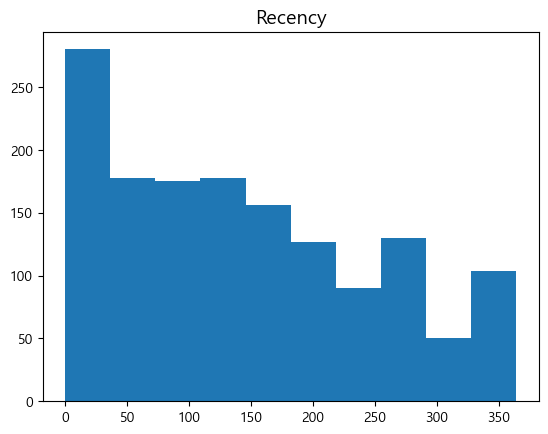

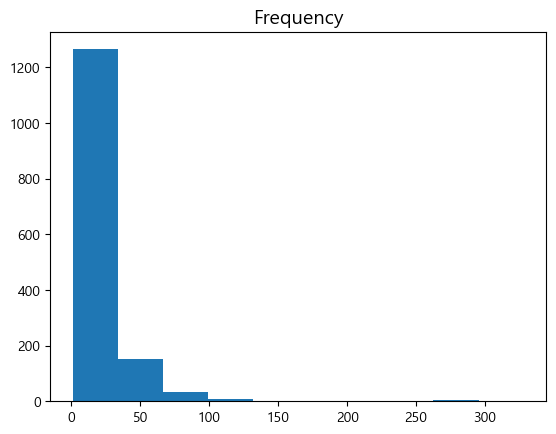

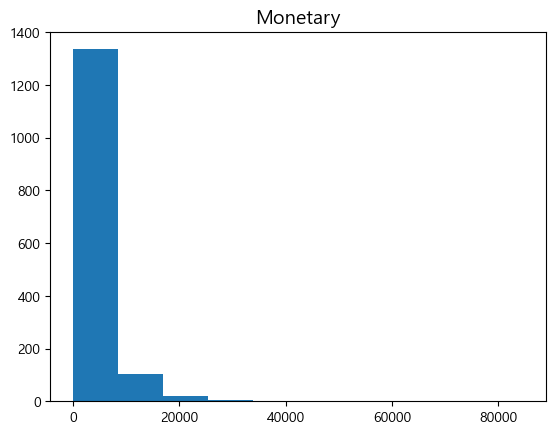

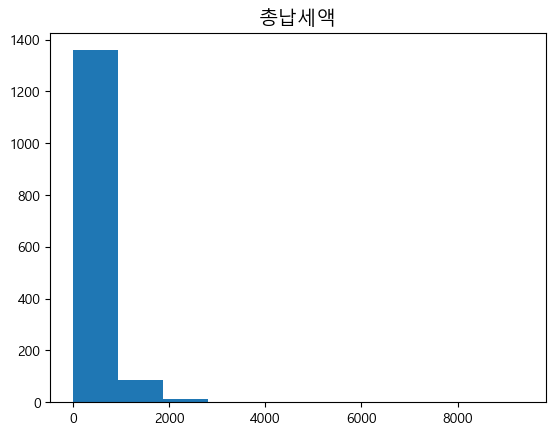

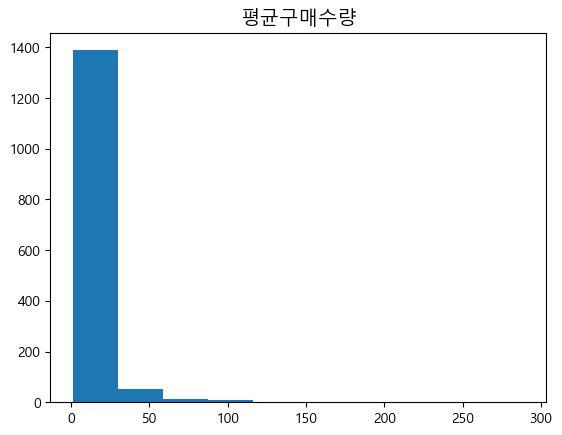

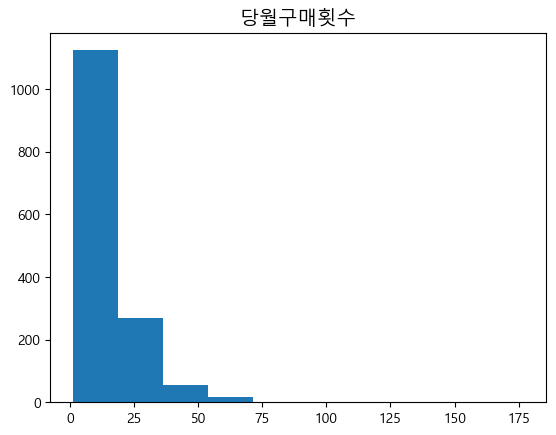

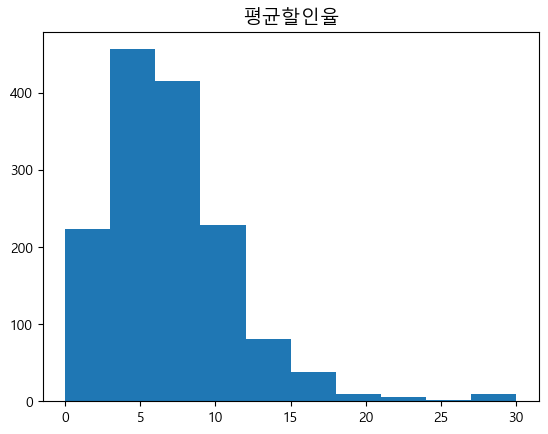

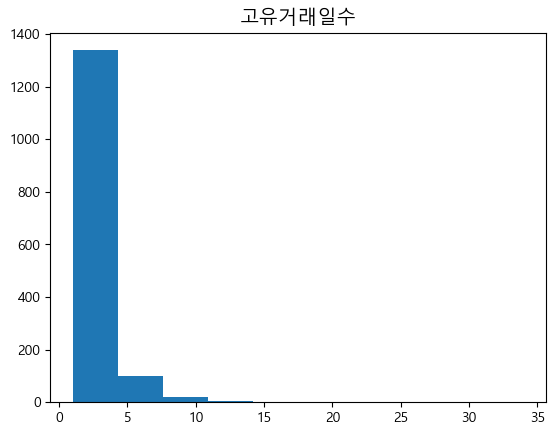

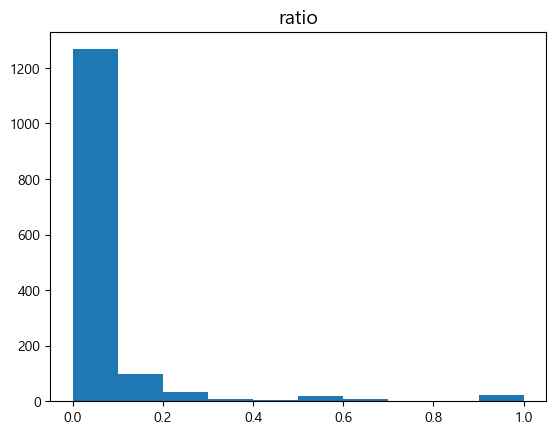

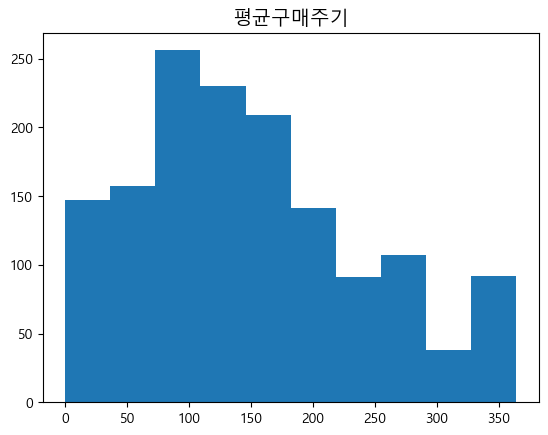

In [130]:
for col in rfm[['Recency','Frequency','Monetary','총납세액','평균구매수량', '당월구매횟수','평균할인율','고유거래일수','ratio','평균구매주기']].columns:
    plt.hist(rfm[col])
    plt.title(col, fontsize=14)
    plt.show()

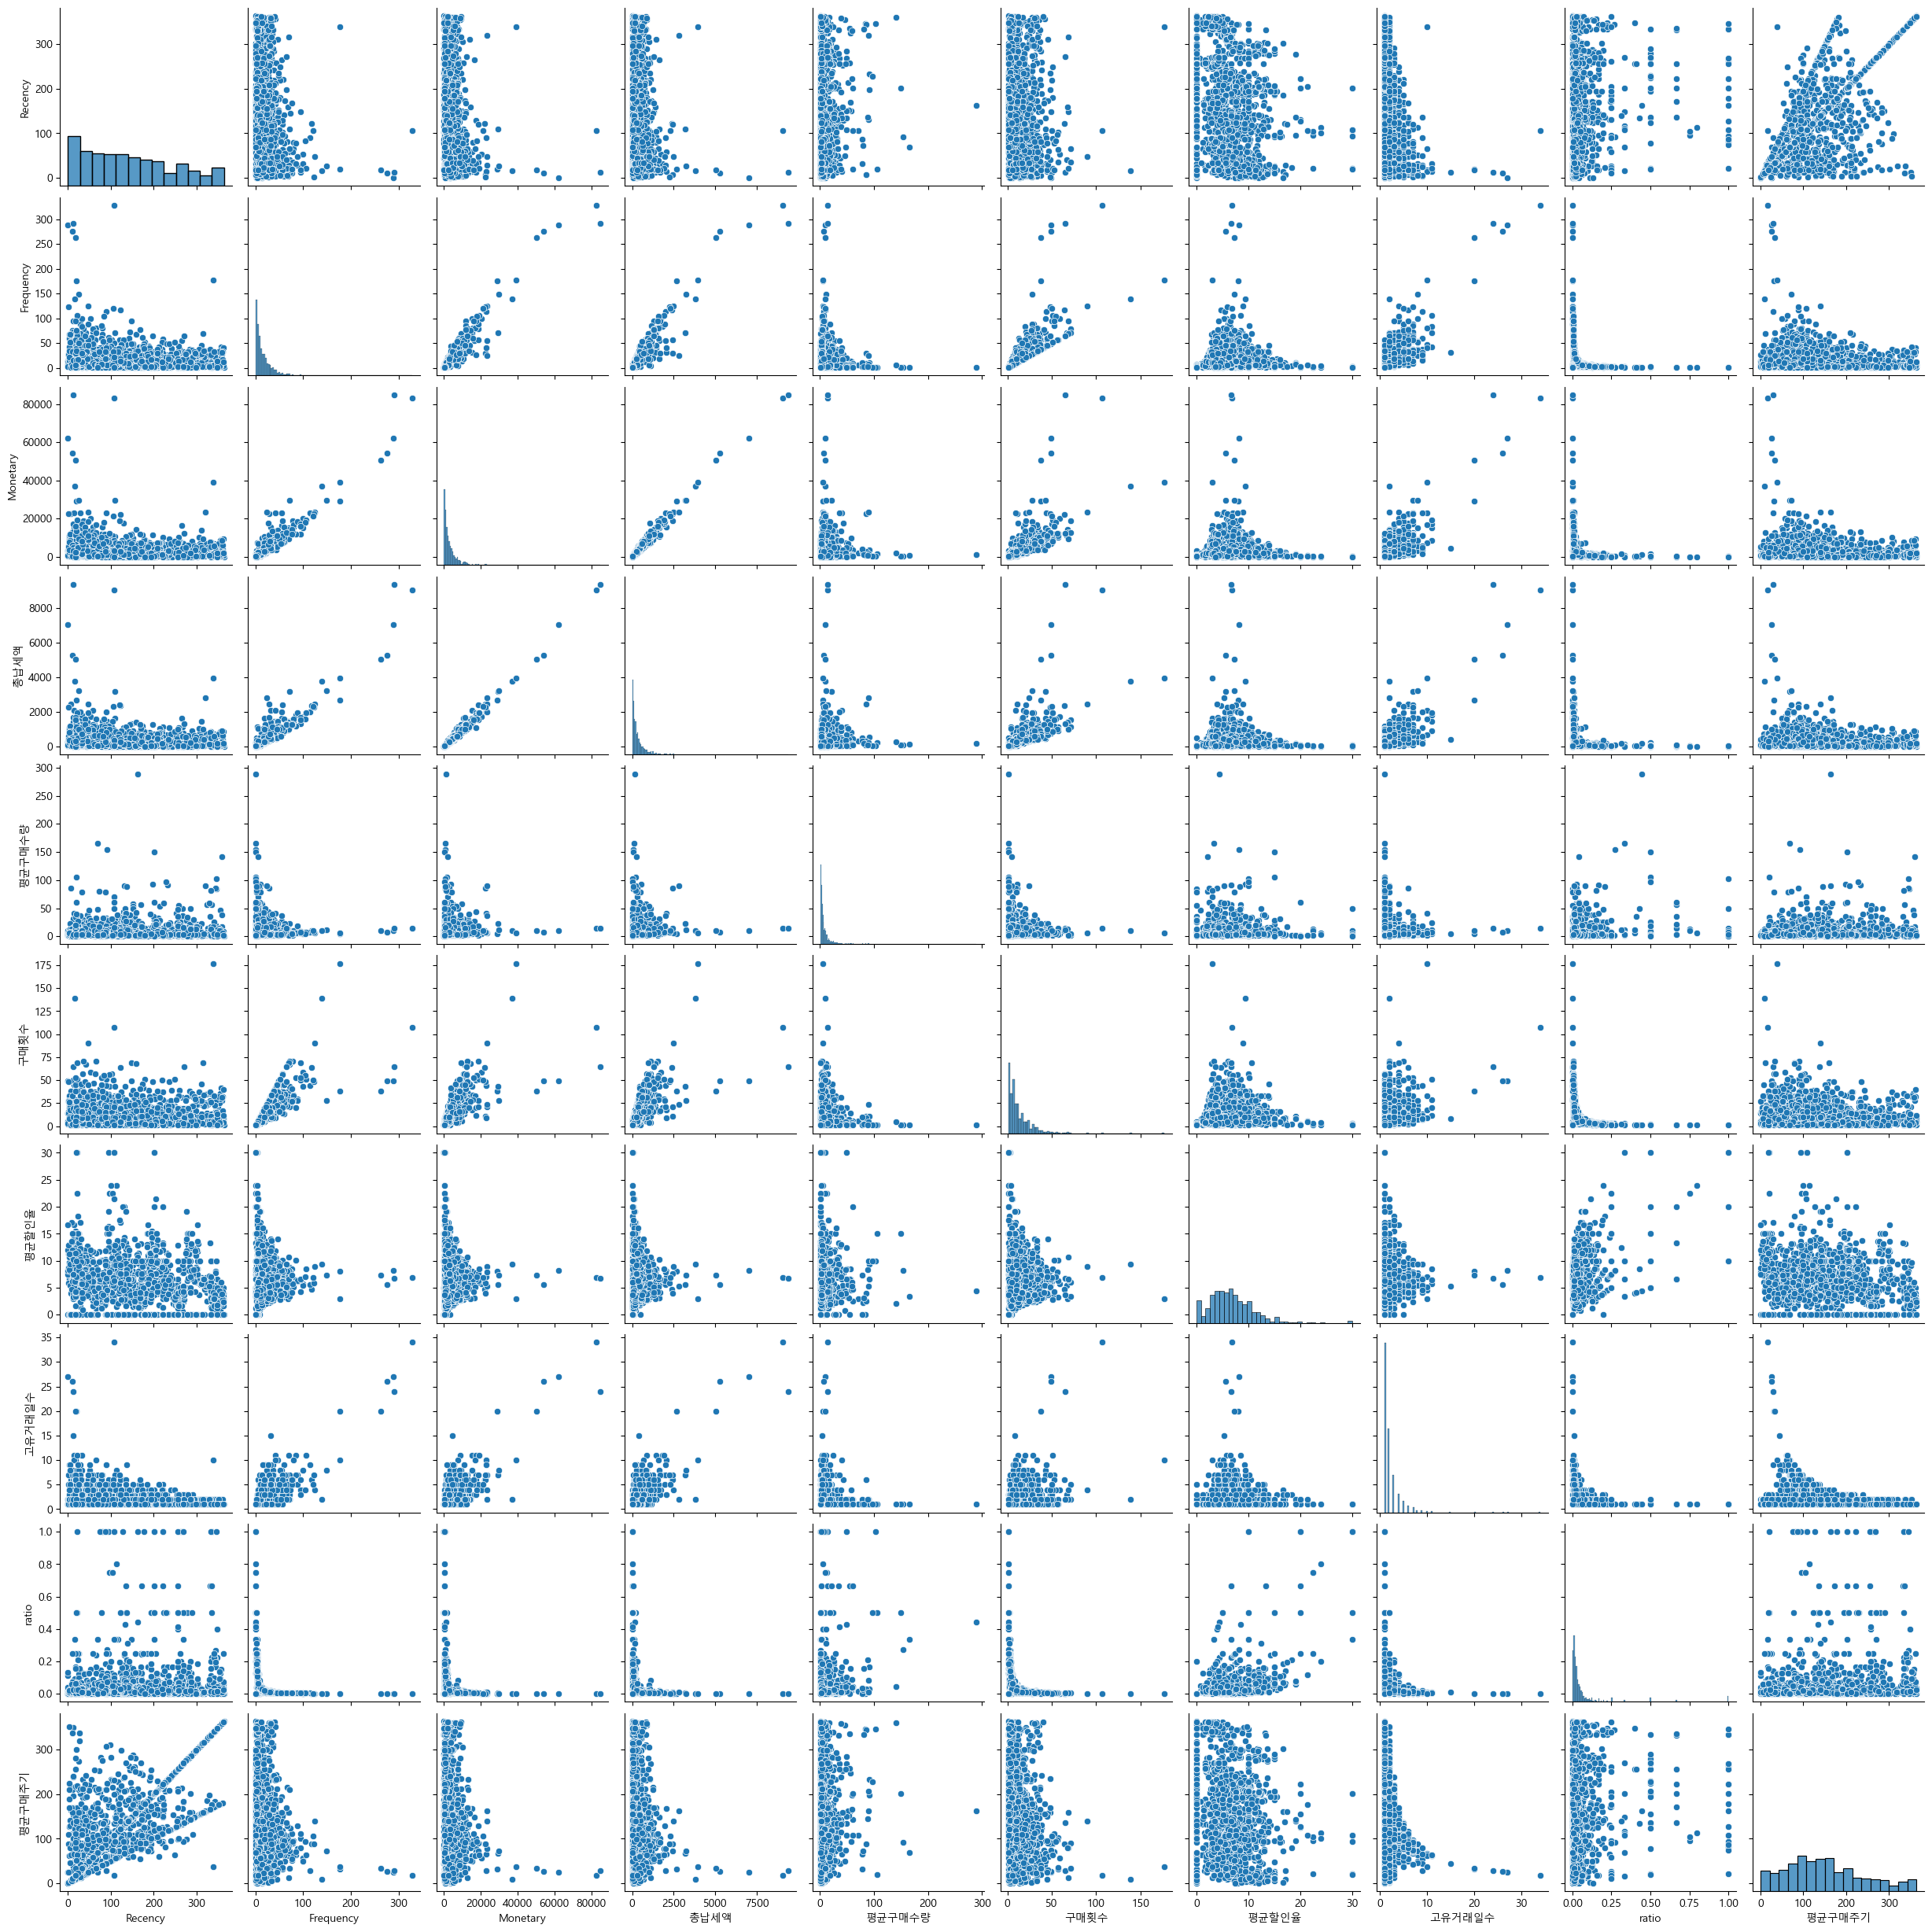

In [124]:
sns.pairplot(rfm[['Recency','Frequency','Monetary','총납세액','평균구매수량', '당월구매횟수','평균할인율','고유거래일수','ratio','평균구매주기']])

In [129]:
rfm[['Recency','Frequency','Monetary','총납세액','평균구매수량', '당월구매횟수','평균할인율','고유거래일수','ratio','평균구매주기']].corr(method='pearson', min_periods=1)

,Recency,Frequency,Monetary,총납세액,평균구매수량,당월구매횟수,평균할인율,고유거래일수,ratio,평균구매주기
Recency,1.000000,-0.218934,-0.204182,-0.176565,0.059750,-0.109909,-0.179300,-0.301409,0.126459,0.762261
Frequency,-0.218934,1.000000,0.949483,0.934530,-0.029558,0.780587,-0.003628,0.770677,-0.236846,-0.228328
Monetary,-0.204182,0.949483,1.000000,0.991906,0.062289,0.725124,-0.018136,0.751528,-0.209667,-0.210503
총납세액,-0.176565,0.934530,0.991906,1.000000,0.082382,0.698204,-0.010935,0.748467,-0.199179,-0.190564
평균구매수량,0.059750,-0.029558,0.062289,0.082382,1.000000,-0.050261,-0.006243,-0.015919,0.116160,0.056418
당월구매횟수,-0.109909,0.780587,0.725124,0.698204,-0.050261,1.000000,-0.008056,0.362713,-0.292781,-0.211365
평균할인율,-0.179300,-0.003628,-0.018136,-0.010935,-0.006243,-0.008056,1.000000,-0.005531,0.444329,-0.164301
고유거래일수,-0.301409,0.770677,0.751528,0.748467,-0.015919,0.362713,-0.005531,1.000000,-0.172272,-0.274333
ratio,0.126459,-0.236846,-0.209667,-0.199179,0.116160,-0.292781,0.444329,-0.172272,1.000000,0.120293
평균구매주기,0.762261,-0.228328,-0.210503,-0.190564,0.056418,-0.211365,-0.164301,-0.274333,0.120293,1.000000


(array([379., 250., 188., 124.,  99.,  82.,  66.,  43.,  37.,  37.]),
 array([7.00000000e+00, 7.63133860e+02, 1.51926772e+03, 2.27540158e+03,
        3.03153544e+03, 3.78766930e+03, 4.54380316e+03, 5.29993702e+03,
        6.05607088e+03, 6.81220474e+03, 7.56833860e+03]),
 <BarContainer object of 10 artists>)

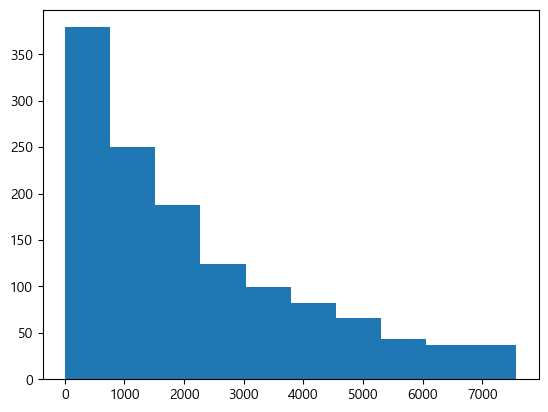

In [92]:
plt.hist(rfm[rfm['Monetary'] <= 7600]['Monetary'])

In [131]:
label_r = [4, 3, 2, 1]
label_f = [1, 2, 3, 4]
label_m = [1, 2, 3, 4]

## EDA
## bins를 만들 때
## 각 컬럼의 히스토그램과 boxplot 등을 봤을 때
## 특정 구간에 밀도가 너무 높아서
## 그 구간을 다시 분할하여 bins 를 생성

# recency_score bins=[0, 70, 180, 280, 364]

rfm["recency_score"] = pd.cut(rfm["Recency"], bins=[0, 30, 90, 180, 364], labels=label_r, include_lowest=True)
rfm["frequency_score"] = pd.cut(rfm["Frequency"], bins=[0, 12, 25, 53, 329], labels=label_f, include_lowest=True)
rfm["monetary_score"] = pd.cut(rfm["Monetary"], bins=[0, 760, 1750, 7594, 90000], labels=label_m, include_lowest=True)
rfm["RFM_SCORE"] = rfm["recency_score"].astype(str) + rfm["frequency_score"].astype(str) + rfm["monetary_score"].astype(str)

In [132]:
seg_map = {
    r'[1-2]1[1-4]': 'Hibernating',          # 1
    r'[1-2]2[1-4]': 'About to Sleep',       # 2
    r'[1-2][3-4][1-4]': 'At Risk',          # 3
    r'3[1-2][1-4]': 'Can\'t Lose',          # 4
    r'3[3-4][1-4]': 'Typical',              # 5
    r'4[1-2][1-2]': 'New Customers',        # 6
    r'4[1-2][3-4]': 'Loyal Customers',      # 7
    r'4[3-4][1-3]': 'Loyal Customers',      # 7
    r'4[3-4][4]': 'VIP'                     # 8
}

rfm['Segmentation'] = rfm['RFM_SCORE'].replace(seg_map, regex=True)

In [133]:
indexing = ['VIP',
            'Loyal Customers',
            'Typical',
            'New Customers',
            'At Risk',
            'Can\'t Lose',
            'About to Sleep',
            'Hibernating'
            ]

In [134]:
seg_stats = pd.DataFrame((rfm['Segmentation'].value_counts()/ rfm['Segmentation'].count()).round(4)*100)

In [135]:
seg_stats.reindex(index=indexing)

,Segmentation
VIP,6.47
Loyal Customers,14.92
Typical,7.49
New Customers,9.40
At Risk,4.56
Can't Lose,27.52
About to Sleep,6.95
Hibernating,22.68


In [98]:
rfm.to_csv('user_feature.csv')

In [99]:
rfm.head()

,고객ID,Recency,Frequency,Monetary,총납세액,평균구매수량,최다구매월,구매횟수,평균할인율,고유거래일수,ratio,평균구매주기,최다구매카테고리,고객지역,recency_score,frequency_score,monetary_score,RFM_SCORE,Segmentation
0,USER_0000,107,1,101.3912,4.6982,3.000000,Sep,1,30.00,1,1.000000,107,Apparel,New York,2,1,1,211,Hibernating
1,USER_0001,59,31,15407.7190,2067.9070,11.032258,Nov,18,8.00,3,0.010753,168,Nest-USA,New York,3,3,4,334,Typical
2,USER_0002,73,8,1596.0858,203.6008,26.125000,Jun,4,11.74,2,0.059783,155,Office,California,3,1,2,312,Can't Lose
3,USER_0003,17,11,1438.5072,148.2642,1.909091,Dec,11,10.59,1,0.032086,17,Apparel,California,4,1,2,412,New Customers
4,USER_0004,107,13,1541.9718,151.7598,4.307692,Sep,13,9.17,1,0.023504,107,Apparel,Chicago,2,2,2,222,About to Sleep


## 클러스터링

### 1. k-means, pca

In [100]:
rfm.groupby('Segmentation')[['고객ID', 'Recency','Frequency','Monetary', 'ratio', '평균구매주기']].agg({'고객ID':'count', 'Recency':'mean', 'Frequency':'mean', 'Monetary':'mean', 'ratio':'mean', '평균구매주기':'mean'}).reindex(index=indexing)


,고객ID,Recency,Frequency,Monetary,ratio,평균구매주기
Segmentation,,,,,,
VIP,46,14.913043,85.065217,18321.559828,0.005505,99.086957
Loyal Customers,107,16.495327,19.887850,3839.401785,0.020658,85.280374
Typical,111,56.639640,45.027027,8943.737360,0.008785,100.972973
New Customers,83,18.024096,5.674699,831.133396,0.096365,46.325301
At Risk,150,192.826667,42.753333,8147.259357,0.009279,147.426667
Can't Lose,200,60.830000,11.195000,2206.805767,0.059094,92.315000
About to Sleep,189,197.259259,17.931217,3243.678490,0.019522,174.317460
Hibernating,582,211.709622,5.292096,896.386481,0.123962,202.960481


In [101]:
rfm_cluster = rfm[['Recency', 'Frequency', 'Monetary', '평균구매주기', 'ratio']]

In [102]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

rfm_cluster_s = pd.DataFrame(data=scaler.fit_transform(rfm_cluster), columns=rfm_cluster.columns)

In [103]:
rfm_cluster_s

,Recency,Frequency,Monetary,평균구매주기,ratio
0,-0.365961,-0.686522,-0.609127,-0.475194,6.103502
1,-0.837001,0.515021,2.147713,0.196981,-0.378026
2,-0.699614,-0.406162,-0.339916,0.053730,-0.056783
3,-1.249160,-0.286007,-0.368298,-1.466928,-0.238254
4,-0.365961,-0.205905,-0.349663,-0.475194,-0.294478
...,...,...,...,...,...
1463,1.233611,-0.606419,-0.505144,1.320945,0.487519
1464,-0.562227,0.034404,-0.153344,-0.563348,-0.310541
1465,0.487799,-0.646470,-0.604241,0.252077,0.780018
1466,-0.738867,-0.686522,-0.567268,-0.893926,-0.448478


In [104]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42, init='k-means++').fit(rfm_cluster_s.iloc[:, :5])
rfm_cluster_s['cluster_result'] = kmeans.labels_
rfm_cluster_s['RFM'] = rfm['Segmentation']


rfm['kmeans'] = rfm_cluster_s['cluster_result']
rfm.groupby('kmeans')[['고객ID', 'Recency','Frequency','Monetary']].agg({'고객ID':'count', 'Recency':'mean', 'Frequency':'mean', 'Monetary':'mean'}).sort_values('Monetary', ascending=False)

,고객ID,Recency,Frequency,Monetary
kmeans,,,,
2,6,80.833333,270.666667,62299.016383
4,178,78.926966,55.556180,11380.031312
1,738,85.060976,13.451220,2402.141659
0,489,252.654397,10.492843,1906.896472
3,57,192.350877,1.052632,155.373591


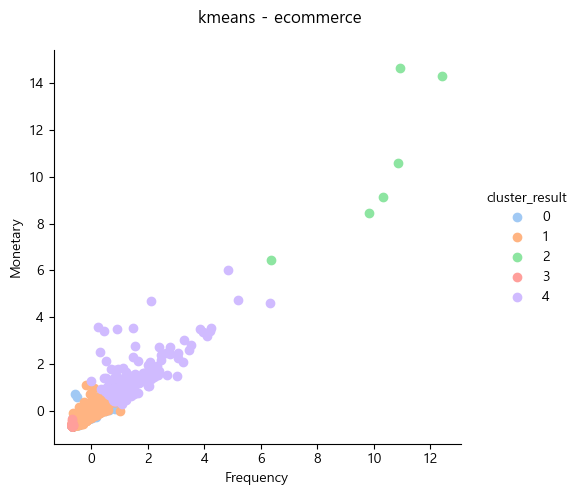

In [105]:
g = sns.FacetGrid(rfm_cluster_s, hue="cluster_result", height = 5, margin_titles = True,
                  palette = sns.color_palette("pastel", 5))
g.map_dataframe(plt.scatter, "Frequency", "Monetary")
g.add_legend()
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("kmeans - ecommerce")
g.set_xlabels("Frequency")
g.set_ylabels("Monetary")

In [106]:
df_centroids = pd.DataFrame(kmeans.cluster_centers_, columns=rfm_cluster_s.iloc[:, :5].columns)
df_centroids['size'] = rfm.groupby('kmeans')['고객ID'].count()

import plotly.graph_objects as go

def plot_radar_from_centroid(df_centroids):
  df_centroids = df_centroids.drop(['size'], axis = 1)
  fig = go.Figure()
  categories = df_centroids.columns
  for row in df_centroids.iterrows():
    fig.add_trace(go.Scatterpolar(
        r=row[1].tolist(),
        theta=categories,
        fill='toself',
        name='cluster {}'.format(row[0])
    ))

  fig.update_layout(
      autosize=False,
      width=1000,
      height=800,
  )
  fig.show()

plot_radar_from_centroid(df_centroids)  

In [107]:
from sklearn.metrics import silhouette_score, silhouette_samples

silhouette_avg = silhouette_score(rfm_cluster_s.iloc[:, :5], kmeans.labels_)
silhouette_avg

0.3776123692058918

In [108]:
for k in range(3, 9):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(rfm_cluster_s.iloc[:, :5])
    silhouette_avg = silhouette_score(rfm_cluster_s.iloc[:, :5], kmeans.labels_)
    print("k = {} -> silhouette index {}".format(k, silhouette_avg))

k = 3 -> silhouette index 0.35307243420463696
k = 4 -> silhouette index 0.3731018100332547
k = 5 -> silhouette index 0.3776123692058918
k = 6 -> silhouette index 0.32782422236134856
k = 7 -> silhouette index 0.3204165998228958
k = 8 -> silhouette index 0.28193516715003614


In [109]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

pca = PCA(n_components = 2)
df_pca = pd.DataFrame(data=pca.fit_transform(rfm_cluster_s.iloc[:, :5]), columns=['pca1', 'pca2'])

kmeans_pca = KMeans(n_clusters=5, random_state=42, init='k-means++').fit(df_pca)

df_pca['cluster_pca_result'] = kmeans_pca.labels_
rfm['cluster_pca_result'] = kmeans_pca.labels_

rfm.groupby('cluster_pca_result')[['고객ID', 'Recency','Frequency','Monetary']].agg({'고객ID':'count', 'Recency':'mean', 'Frequency':'mean', 'Monetary':'mean'}).sort_values('Monetary', ascending=False)

,고객ID,Recency,Frequency,Monetary
cluster_pca_result,,,,
4,6,80.833333,270.666667,62299.016383
2,183,81.901639,55.076503,11244.014789
0,491,57.079430,13.800407,2522.190373
3,521,169.654511,11.341651,1924.574148
1,267,299.370787,8.400749,1651.690924


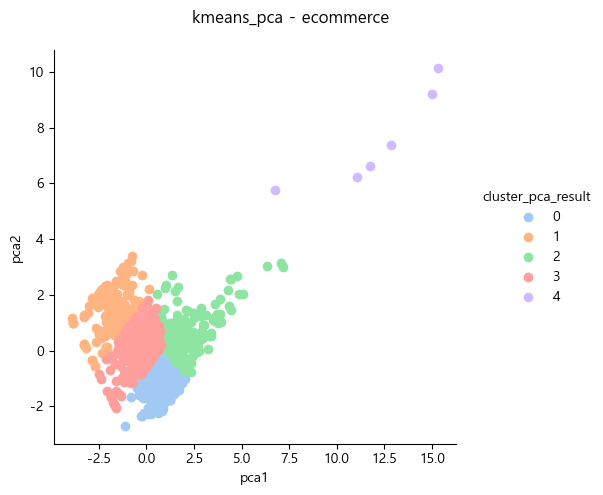

In [110]:
g = sns.FacetGrid(df_pca, hue="cluster_pca_result", height = 5, margin_titles = True,
                  palette = sns.color_palette("pastel", 5))
g.map_dataframe(plt.scatter, "pca1", "pca2")
g.add_legend()
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("kmeans_pca - ecommerce")
g.set_xlabels("pca1")
g.set_ylabels("pca2")

In [111]:
# df_centroids = pd.DataFrame(kmeans_pca.cluster_centers_, columns=rfm_cluster_s.iloc[:, :5].columns)
# df_centroids['size'] = rfm.groupby('cluster_pca_result')['고객ID'].count()

# import plotly.graph_objects as go

# def plot_radar_from_centroid(df_centroids):
#   df_centroids = df_centroids.drop(['size'], axis = 1)
#   fig = go.Figure()
#   categories = df_centroids.columns
#   for row in df_centroids.iterrows():
#     fig.add_trace(go.Scatterpolar(
#         r=row[1].tolist(),
#         theta=categories,
#         fill='toself',
#         name='cluster {}'.format(row[0])
#     ))

#   fig.update_layout(
#       autosize=False,
#       width=1000,
#       height=800,
#   )
#   fig.show()

# plot_radar_from_centroid(df_centroids)  

### 2. t-SNE

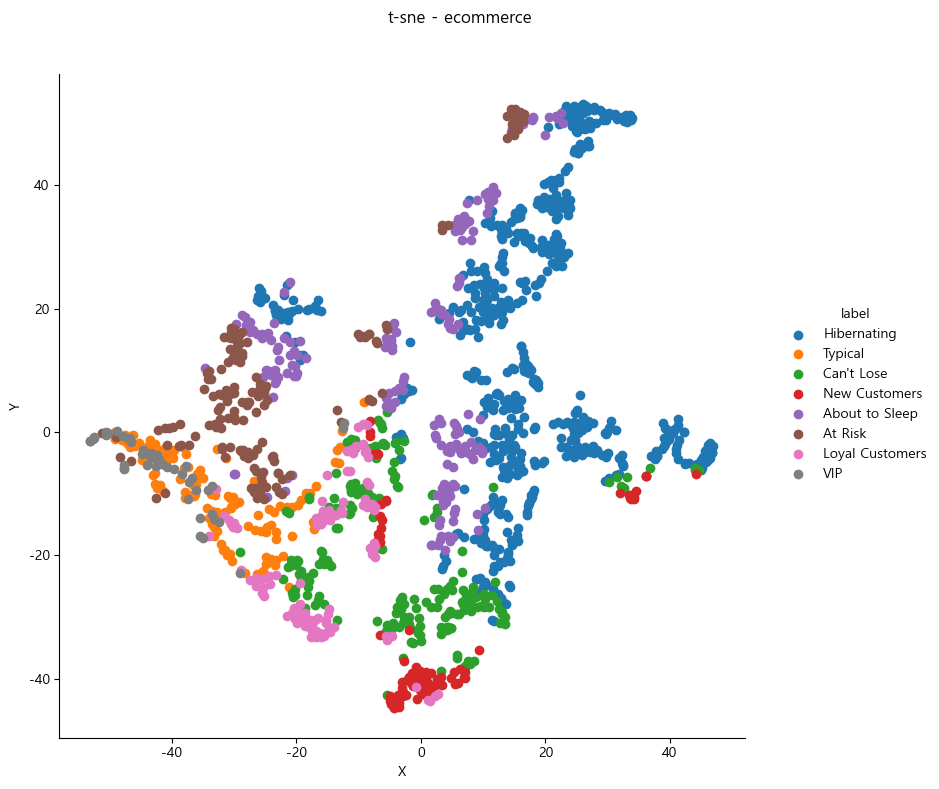

In [112]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)

df_ecommerce_tsne = pd.DataFrame(data = tsne.fit_transform(rfm_cluster_s.iloc[:, :5]), columns = ['col1', 'col2'])
df_ecommerce_tsne['label'] = rfm_cluster_s['RFM']

h = sns.FacetGrid(df_ecommerce_tsne, hue="label", height = 8, margin_titles = True,
                  palette = sns.color_palette())
h.map_dataframe(plt.scatter, "col1", "col2")
h.add_legend()
h.fig.subplots_adjust(top=0.9)
h.fig.suptitle("t-sne - ecommerce")
h.set_xlabels("X")
h.set_ylabels("Y")

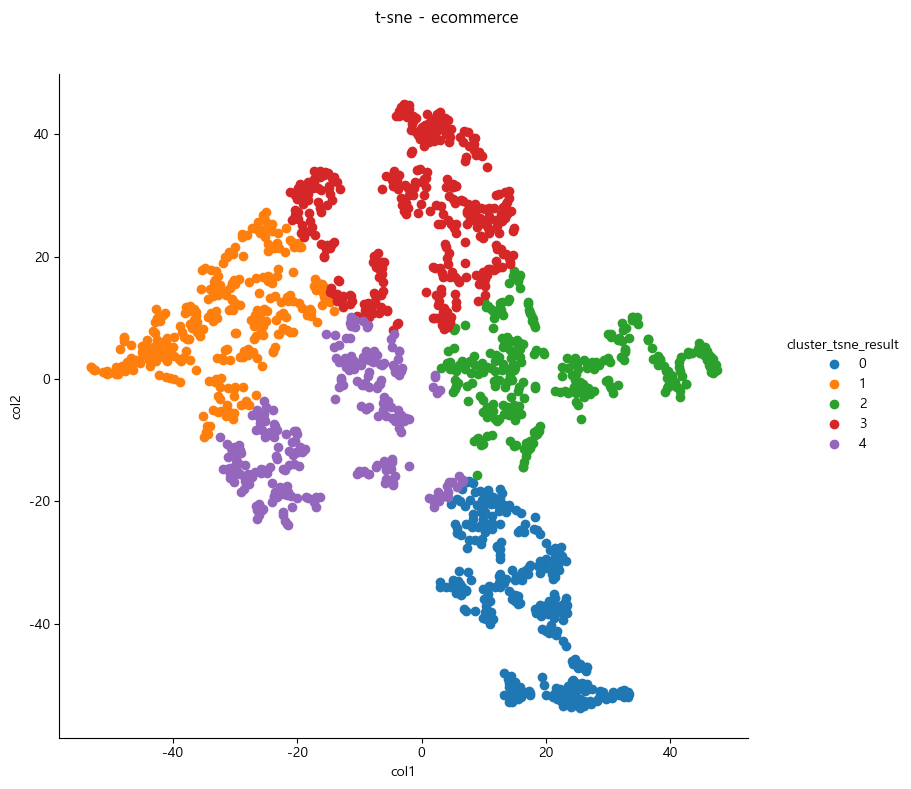

In [113]:


tsne_2 = TSNE(n_components=2)

df_ecommerce_tsne = pd.DataFrame(data = tsne.fit_transform(rfm_cluster_s.iloc[:, :5]), columns = ['col1', 'col2'])
df_ecommerce_tsne['label'] = rfm_cluster_s['RFM']


kmeans_tsne = KMeans(n_clusters=5, random_state=42, init='k-means++').fit(df_ecommerce_tsne[['col1', 'col2']])
df_ecommerce_tsne['cluster_tsne_result'] = kmeans_tsne.labels_



i = sns.FacetGrid(df_ecommerce_tsne, hue="cluster_tsne_result", height = 8, margin_titles = True,
                  palette = sns.color_palette())
i.map_dataframe(plt.scatter, "col1", "col2")
i.add_legend()
i.fig.subplots_adjust(top=0.9)
i.fig.suptitle("t-sne - ecommerce")
i.set_xlabels("col1")
i.set_ylabels("col2")

In [114]:
# df_centroids = pd.DataFrame(kmeans_tsne.cluster_centers_, columns=rfm_cluster_s.iloc[:, :5].columns)
# df_centroids['size'] = rfm.groupby('cluster_pca_result')['고객ID'].count()

# import plotly.graph_objects as go

# def plot_radar_from_centroid(df_centroids):
#   df_centroids = df_centroids.drop(['size'], axis = 1)
#   fig = go.Figure()
#   categories = df_centroids.columns
#   for row in df_centroids.iterrows():
#     fig.add_trace(go.Scatterpolar(
#         r=row[1].tolist(),
#         theta=categories,
#         fill='toself',
#         name='cluster {}'.format(row[0])
#     ))

#   fig.update_layout(
#       autosize=False,
#       width=1000,
#       height=800,
#   )
#   fig.show()

# plot_radar_from_centroid(df_centroids)  

In [115]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

dend_ecommerce = rfm_cluster_s.iloc[:, :5]

plt.figure(figsize=(15,10))
plt.title('Dendrogram')
plt.xlabel('users')
plt.ylabel('Euclidean distances')
dgram = dendrogram(linkage(dend_ecommerce, method = 'ward'))
plt.show()


KeyboardInterrupt: 

In [ ]:
ecommerce_clustering = AgglomerativeClustering(n_clusters = 5, affinity = 'euclidean', linkage = 'ward')
ecommerce_label = ecommerce_clustering.fit_predict(dend_ecommerce)
ecommerce_label

array([1, 4, 0, ..., 0, 0, 4], dtype=int64)

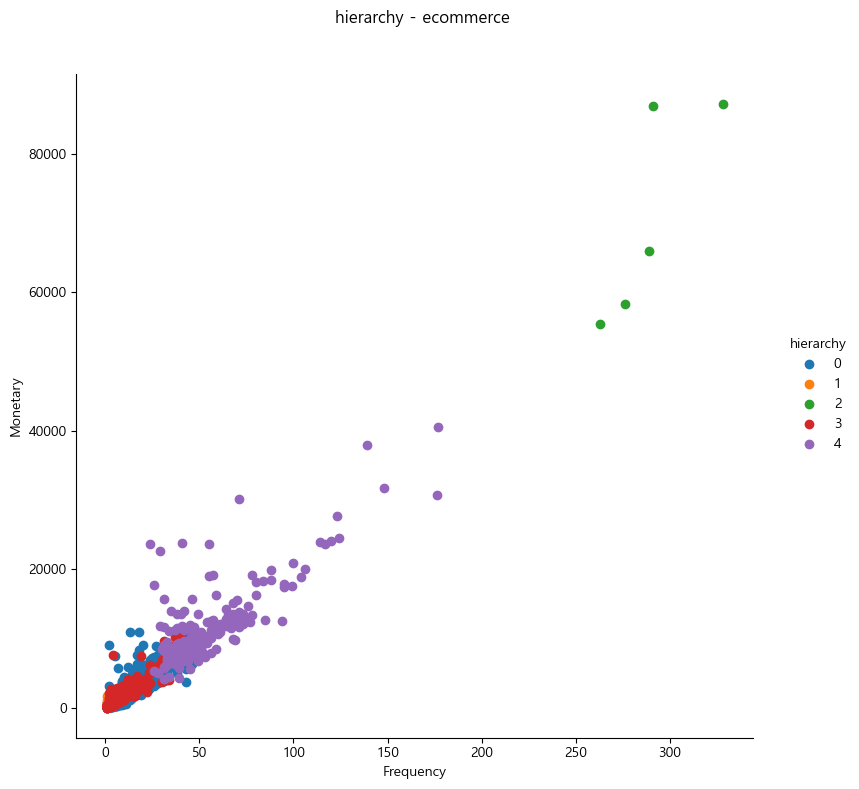

In [ ]:
rfm['hierarchy'] = ecommerce_label

j = sns.FacetGrid(rfm, hue="hierarchy", height = 8, margin_titles = True,
                  palette = sns.color_palette())
j.map_dataframe(plt.scatter, "Frequency", "Monetary")
j.add_legend()
j.fig.subplots_adjust(top=0.9)
j.fig.suptitle("hierarchy - ecommerce")
j.set_xlabels("Frequency")
j.set_ylabels("Monetary")

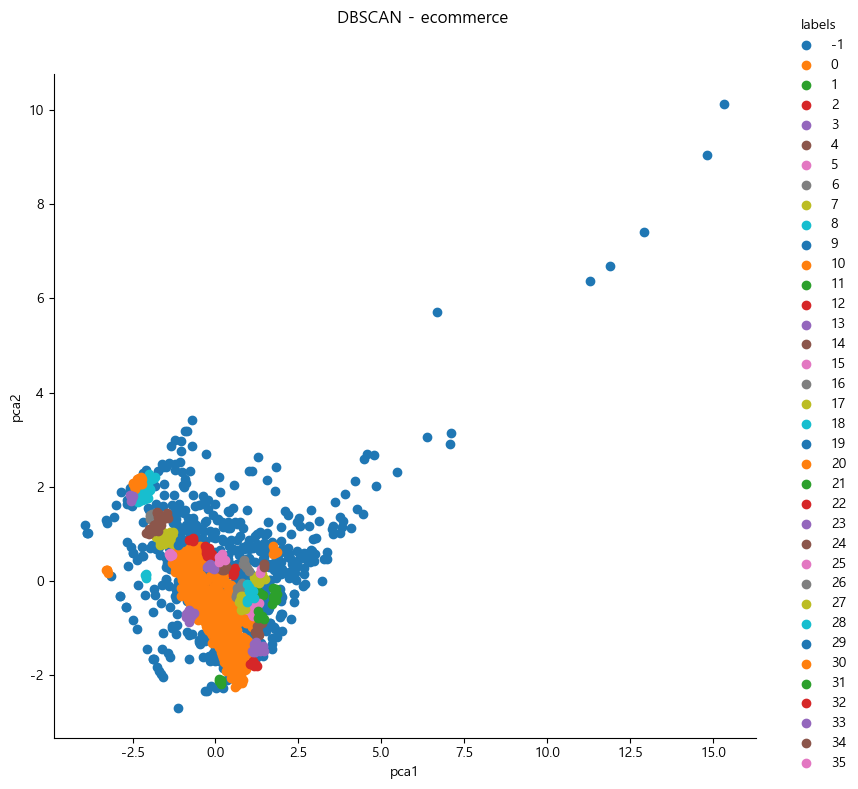

In [ ]:
from sklearn.cluster import DBSCAN



dbscan = DBSCAN(eps=0.1, min_samples=4).fit(df_pca[['pca1', 'pca2']])
y_pred = dbscan.labels_

df_pca['labels'] = y_pred

j = sns.FacetGrid(df_pca, hue="labels", height = 8, margin_titles = True,
                  palette = sns.color_palette())
j.map_dataframe(plt.scatter, "pca1", "pca2")
j.add_legend()
j.fig.subplots_adjust(top=0.9)
j.fig.suptitle("DBSCAN - ecommerce")
j.set_xlabels("pca1")
j.set_ylabels("pca2")

### EDA

In [ ]:
##### 비즈니스 인사이트 테이블

In [ ]:
#### ROAS 지표

df.head()

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,성별,고객지역,가입기간,GST,월,쿠폰코드,할인율,오프라인비용,온라인비용,true_discount,총금액
0,USER_1358,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used,남,Chicago,12,0.10,Jan,ELEC10,10.0,4500,2424.5,1,158.6729
1,USER_1358,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.5,Used,남,Chicago,12,0.10,Jan,ELEC10,10.0,4500,2424.5,1,158.6729
2,USER_1358,Transaction_0002,2019-01-01,Product_0904,Office,1,2.05,6.5,Used,남,Chicago,12,0.10,Jan,OFF10,10.0,4500,2424.5,1,8.5295
3,USER_1358,Transaction_0003,2019-01-01,Product_0203,Apparel,5,17.53,6.5,Not Used,남,Chicago,12,0.18,Jan,SALE10,10.0,4500,2424.5,0,109.9270
4,USER_1358,Transaction_0003,2019-01-01,Product_0848,Bags,1,16.50,6.5,Used,남,Chicago,12,0.18,Jan,AIO10,10.0,4500,2424.5,1,24.0230


In [ ]:
df['총마케팅비용'] = df['오프라인비용'] + df['온라인비용']
df['ma_total_marketing'] = df['총마케팅비용'].rolling(7).mean().fillna(method='bfill')
df

,고객ID,거래ID,거래날짜,제품ID,제품카테고리,수량,평균금액,배송료,쿠폰상태,성별,...,GST,월,쿠폰코드,할인율,오프라인비용,온라인비용,true_discount,총금액,총마케팅비용,ma_total_marketing
0,USER_1358,Transaction_0000,2019-01-01,Product_0981,Nest-USA,1,153.71,6.50,Used,남,...,0.10,Jan,ELEC10,10.0,4500,2424.50,1,158.67290,6924.50,6924.50
1,USER_1358,Transaction_0001,2019-01-01,Product_0981,Nest-USA,1,153.71,6.50,Used,남,...,0.10,Jan,ELEC10,10.0,4500,2424.50,1,158.67290,6924.50,6924.50
2,USER_1358,Transaction_0002,2019-01-01,Product_0904,Office,1,2.05,6.50,Used,남,...,0.10,Jan,OFF10,10.0,4500,2424.50,1,8.52950,6924.50,6924.50
3,USER_1358,Transaction_0003,2019-01-01,Product_0203,Apparel,5,17.53,6.50,Not Used,남,...,0.18,Jan,SALE10,10.0,4500,2424.50,0,109.92700,6924.50,6924.50
4,USER_1358,Transaction_0003,2019-01-01,Product_0848,Bags,1,16.50,6.50,Used,남,...,0.18,Jan,AIO10,10.0,4500,2424.50,1,24.02300,6924.50,6924.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52919,USER_0504,Transaction_25056,2019-12-31,Product_0976,Nest-USA,1,121.30,6.50,Clicked,여,...,0.10,Dec,ELEC30,30.0,4000,2058.75,0,139.93000,6058.75,6058.75
52920,USER_0504,Transaction_25057,2019-12-31,Product_0413,Apparel,1,48.92,6.50,Used,여,...,0.18,Dec,SALE30,30.0,4000,2058.75,1,46.90792,6058.75,6058.75
52921,USER_0504,Transaction_25058,2019-12-31,Product_0989,Nest-USA,1,151.88,6.50,Used,여,...,0.10,Dec,ELEC30,30.0,4000,2058.75,1,123.44760,6058.75,6058.75
52922,USER_0562,Transaction_25059,2019-12-31,Product_0985,Nest-USA,5,80.52,6.50,Clicked,여,...,0.10,Dec,ELEC30,30.0,4000,2058.75,0,449.36000,6058.75,6058.75


In [ ]:
marketing = df[['거래날짜', '총마케팅비용']].drop_duplicates().reset_index(drop=True)

marketing2 = df[['거래날짜', '총마케팅비용']].drop_duplicates().reset_index(drop=True)
marketing2['ma_total_marketing'] = marketing2['총마케팅비용'].rolling(7).mean().fillna(method='bfill')
marketing2 = marketing2.rename(columns={'ma_total_marketing':'총마케팅비용(7일ma)'})
marketing2

,거래날짜,총마케팅비용,총마케팅비용(7일ma)
0,2019-01-01,6924.50,7477.351429
1,2019-01-02,7980.36,7477.351429
2,2019-01-03,6076.38,7477.351429
3,2019-01-04,7428.55,7477.351429
4,2019-01-05,8555.30,7477.351429
...,...,...,...
360,2019-12-27,7396.87,6754.795714
361,2019-12-28,7246.84,6702.525714
362,2019-12-29,6546.58,6664.971429
363,2019-12-30,4674.31,6375.631429


In [ ]:
sales = df.groupby('거래날짜')['총금액'].sum().reset_index()
sales

,거래날짜,총금액
0,2019-01-01,9039.42048
1,2019-01-02,15269.39436
2,2019-01-03,29145.65155
3,2019-01-04,19500.23722
4,2019-01-05,21260.25480
...,...,...
360,2019-12-27,14371.81383
361,2019-12-28,11192.15088
362,2019-12-29,12299.47787
363,2019-12-30,8440.30569


In [ ]:
roas1 = pd.merge(marketing, sales, how='left', on='거래날짜')
roas1['ratio'] = roas1['총금액'] / roas1['총마케팅비용']
roas1.sort_values('ratio', ascending=False).head(10)

,거래날짜,총마케팅비용,총금액,ratio
150,2019-05-31,1510.30,25596.54440,16.947987
29,2019-01-30,1681.86,22468.06098,13.359055
94,2019-04-05,4842.68,59951.48052,12.379815
151,2019-06-01,820.25,10140.35572,12.362518
31,2019-02-01,1392.67,17027.52846,12.226535
26,2019-01-27,1687.86,20095.25379,11.905759
23,2019-01-24,1560.02,17620.19628,11.294853
213,2019-08-02,3655.96,40533.19244,11.086881
149,2019-05-30,1762.38,18826.97940,10.682701
30,2019-01-31,2080.14,22123.26392,10.635469


In [ ]:
roas2 = pd.merge(marketing2, sales, how='left', on='거래날짜')
roas2['ratio'] = roas2['총금액'] / roas2['총마케팅비용(7일ma)']
roas2.sort_values('ratio', ascending=False).head(10)


,거래날짜,총마케팅비용,총마케팅비용(7일ma),총금액,ratio
94,2019-04-05,4842.68,4289.407143,59951.48052,13.976636
29,2019-01-30,1681.86,1788.870000,22468.06098,12.559918
213,2019-08-02,3655.96,3241.630000,40533.19244,12.503954
30,2019-01-31,2080.14,1863.172857,22123.26392,11.873973
150,2019-05-31,1510.30,2243.272857,25596.54440,11.410357
330,2019-11-27,5819.58,5001.338571,56662.02888,11.329373
198,2019-07-18,4408.61,3999.448571,42947.02071,10.738236
107,2019-04-18,5476.58,5430.738571,54471.40715,10.030202
31,2019-02-01,1392.67,1758.561429,17027.52846,9.682646
26,2019-01-27,1687.86,2193.951429,20095.25379,9.159389


<AxesSubplot:xlabel='거래날짜', ylabel='ratio'>

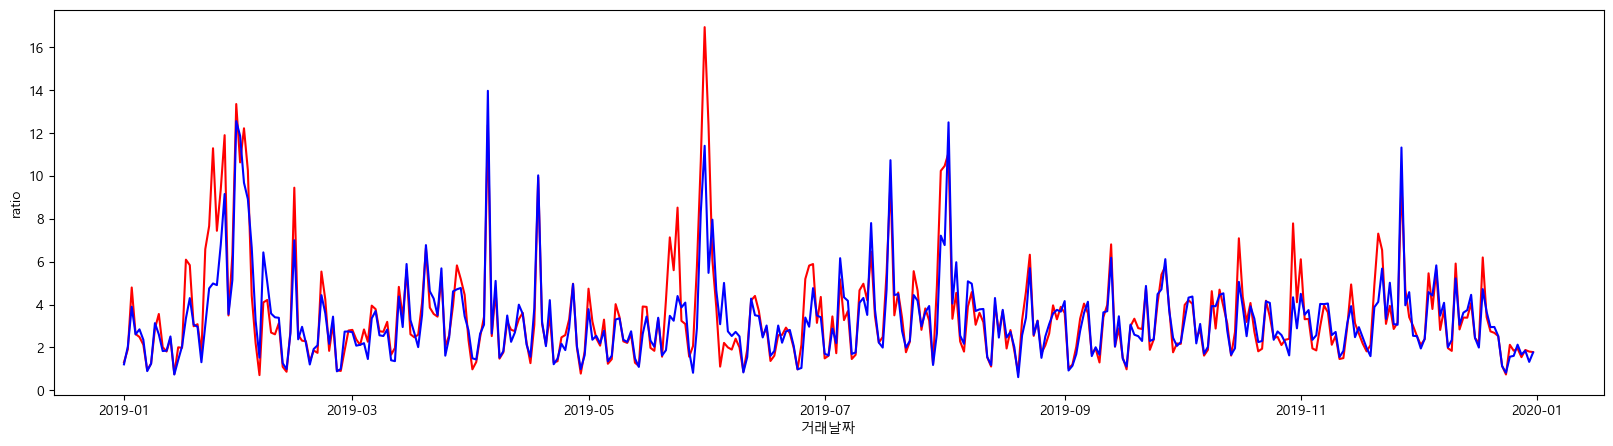

In [ ]:
plt.figure(figsize=(20, 5))
sns.lineplot(data=roas1, x='거래날짜', y='ratio', color='red')
sns.lineplot(data=roas2, x='거래날짜', y='ratio', color='blue')


# ratio(빨강) = 총비용 / 총마케팅비용
# ratio(파랑) = 총비용 / 총마케팅비용(이동평균)

# 총마케팅비용(이동평균) - 원본의 고점을 낮게 만드는 효과

# 마케팅의 특성상 직관적으로 볼때는 이동평균을 하는게 맞아보이는데


In [ ]:
week = []
cut = 0


for i in range(1, 54):
    for j in range(7):
        week.append(i)
        if len(week) == len(roas1):
            break
    if len(week) == len(roas1):
        break

roas1['week'] = np.array(week).reshape(len(roas1), -1)
roas1

,거래날짜,총마케팅비용,총금액,ratio,week
0,2019-01-01,6924.50,9039.42048,1.305426,1
1,2019-01-02,7980.36,15269.39436,1.913372,1
2,2019-01-03,6076.38,29145.65155,4.796549,1
3,2019-01-04,7428.55,19500.23722,2.625040,1
4,2019-01-05,8555.30,21260.25480,2.485039,1
...,...,...,...,...,...
360,2019-12-27,7396.87,14371.81383,1.942959,52
361,2019-12-28,7246.84,11192.15088,1.544418,52
362,2019-12-29,6546.58,12299.47787,1.878764,52
363,2019-12-30,4674.31,8440.30569,1.805679,52


In [ ]:
week_core = pd.DataFrame(roas1.groupby('week')[['총마케팅비용', '총금액']].sum()).reset_index()
week_core['ratio_week'] = week_core['총금액'] / week_core['총마케팅비용']
week_core.sort_values('ratio_week', ascending=False).head(10)

,week,총마케팅비용,총금액,ratio_week
21,22,10081.86,82926.69858,8.225337
3,4,13710.42,110229.52235,8.039836
4,5,13870.26,105175.22745,7.582787
30,31,21959.29,138445.68213,6.304652
28,29,28218.83,125851.33122,4.459835
20,21,18022.79,76393.20878,4.238700
46,47,33355.78,139378.94608,4.178555
47,48,37320.98,155668.44771,4.171071
11,12,26066.40,108427.85349,4.159679
13,14,31863.55,132045.72795,4.144100


<AxesSubplot:xlabel='week', ylabel='총마케팅비용'>

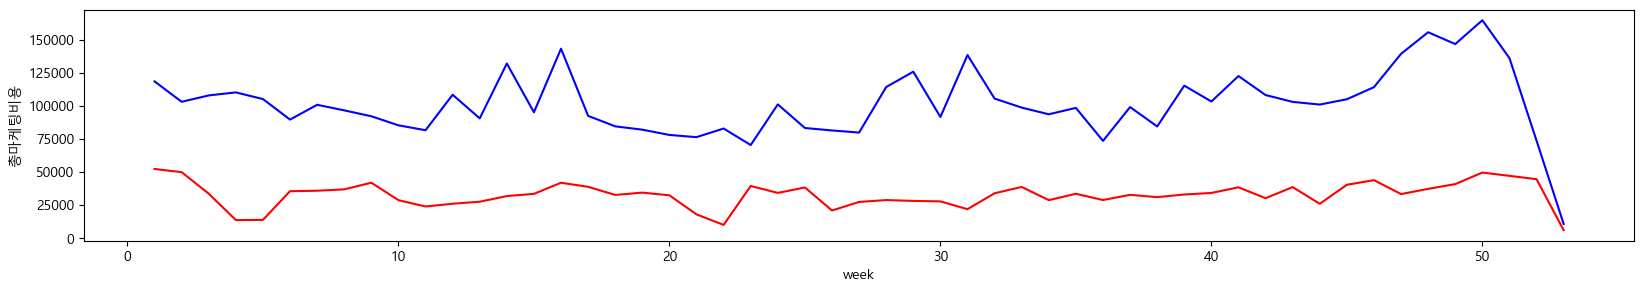

In [ ]:
plt.figure(figsize=(20, 3))
sns.lineplot(data=week_core, x='week', y='총마케팅비용', color='red')
sns.lineplot(data=week_core, x='week', y='총금액', color='blue')


<AxesSubplot:xlabel='week', ylabel='ratio_week'>

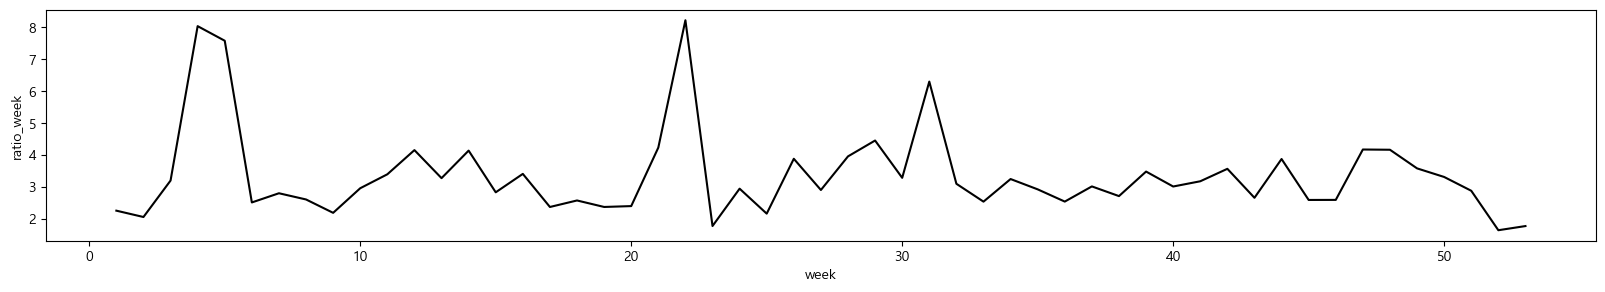

In [ ]:
plt.figure(figsize=(20, 3))
sns.lineplot(data=week_core, x='week', y='ratio_week', color='black')